## 🌍📓 Multi-Market Vectorized Simulation Based Forecast


## 🧠 Objective

This notebook focuses on implementing a **vectorized simulation framework** to model patient uptake of Drug X across multiple countries and simulation runs. Compared to earlier loop-based approaches, the vectorized methods significantly improve computational efficiency and scalability—especially useful when forecasting over long horizons and multiple markets with hundreds or thousands of simulations.

I will:
- Reuse and modularize four core simulation functions (`simulate_eligibles`, `simulate_seen_by_users`, `simulate_new_pts_treated`, and `simulate_treatment_persistence`).
- Use them in a pipeline to simulate patient uptake in a performant way.
- Visualize results to compare variability across simulation runs and time.


In [1]:
# === 📦 Import core libraries and vectorized simulation functions ===
# These functions are stored in `utils_vect.py` to promote modularity and performance.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils_vect import (
    simulate_eligibles,
    simulate_seen_by_users,
    simulate_new_pts_treated,
    simulate_treatment_persistence
)

np.random.seed(123)  # Set a fixed seed for reproducibility

## 🧭 Define Forecast Scope and Country Parameters

In this section, I define:
- A consistent simulation time frame (`n_months`) and number of simulations (`n_simulations`)
- Market-specific parameters for Drug X's uptake across selected countries
- The number of months to forecast per country, ensuring **at least `n_months` after each launch date**, aligned with the latest market launch.

This setup ensures that all countries are forecasted to the same endpoint, which is critical for cross-market comparison.

In [2]:
# 📌 Global parameters for all simulations
n_months = 60
n_simulations = 500

# Parameters for persistence modeling
median_duration = 10 # median months patients stay on treatment
max_duration = 24 # max months of treatment duration cap

# 🗺️ Define mock market-level input data
country_params = {
    'China': {'annual_eligibles': 50000,
              'launch_date': '2022-01-01',
              'initial_user_share': 0.1,
              'max_user_share': 0.7,
              'months_to_peak': 36,
              'probability_to_prescribe': 0.25},
    'Germany': {'annual_eligibles': 5500,
                'launch_date': '2019-12-01',
                'initial_user_share': 0.1,
                'max_user_share': 0.7,
                'months_to_peak': 36,
                'probability_to_prescribe': 0.25},
    'France': {'annual_eligibles': 4300,
               'launch_date': '2024-06-01',
               'initial_user_share': 0.1,
               'max_user_share': 0.7,
               'months_to_peak': 36,
               'probability_to_prescribe': 0.25},
    'UK': {'annual_eligibles': 4400,
           'launch_date': '2019-10-01',
           'initial_user_share': 0.1,
           'max_user_share': 0.7,
           'months_to_peak': 36,
           'probability_to_prescribe': 0.25},
    'Italy': {'annual_eligibles': 3900,
              'launch_date': '2024-12-01',
              'initial_user_share': 0.1,
              'max_user_share': 0.7,
              'months_to_peak': 36,
              'probability_to_prescribe': 0.25},
    'Spain': {'annual_eligibles': 3100,
              'launch_date': '2022-04-01',
              'initial_user_share': 0.1,
              'max_user_share': 0.7,
              'months_to_peak': 36,
              'probability_to_prescribe': 0.25},
    'US': {'annual_eligibles': 22000,
           'launch_date': '2017-07-01',
           'initial_user_share': 0.1,
           'max_user_share': 0.7,
           'months_to_peak': 36,
           'probability_to_prescribe': 0.25},
    'Japan': {'annual_eligibles': 8300,
             'launch_date': '2025-01-01',
             'initial_user_share': 0.1,
             'max_user_share': 0.7,
             'months_to_peak': 36,
             'probability_to_prescribe': 0.25}
}

In [3]:
# Convert to DataFrame for ease of manipulation
country_params = pd.DataFrame(country_params)
country_params

,China,Germany,France,UK,Italy,Spain,US,Japan
annual_eligibles,50000,5500,4300,4400,3900,3100,22000,8300
launch_date,2022-01-01,2019-12-01,2024-06-01,2019-10-01,2024-12-01,2022-04-01,2017-07-01,2025-01-01
initial_user_share,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
max_user_share,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7
months_to_peak,36,36,36,36,36,36,36,36
probability_to_prescribe,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25


In [4]:
# Determine latest launch to align forecast horizons
last_launch_date = country_params.loc['launch_date'].max()

# Calculate country-specific forecast lengths to ensure n_months post-launch for all
n_months_to_forecast = []
for launch in country_params.loc['launch_date']:
    n_months_to_forecast.append(len(pd.date_range(launch,last_launch_date,freq='M')) + n_months)

# Add computed forecast lengths to the DataFrame
country_params.loc['months_to_forecast'] = n_months_to_forecast
# View the final country parameters table
country_params


,China,Germany,France,UK,Italy,Spain,US,Japan
annual_eligibles,50000,5500,4300,4400,3900,3100,22000,8300
launch_date,2022-01-01,2019-12-01,2024-06-01,2019-10-01,2024-12-01,2022-04-01,2017-07-01,2025-01-01
initial_user_share,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
max_user_share,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7
months_to_peak,36,36,36,36,36,36,36,36
probability_to_prescribe,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25
months_to_forecast,96,121,67,123,61,93,150,60


## 🔁 Run Vectorized Simulations by Market

I now simulate the full patient uptake cascade for Drug X in each country using the previously defined vectorized functions:

1. **Eligible patients** — simulated monthly with random incidence.
2. **Patients seen by users** — using uptake curve and uncertainty.
3. **Patients treated** — based on treatment probability.
4. **Patients on treatment** — applying exponential persistence.

Each country runs independently, using its own launch date and parameter set, and results are stored for post-simulation analysis.

In [5]:
# 🌀 Run simulations for each country
results = {}

for country in country_params.columns:
    months = int(country_params.loc['months_to_forecast', country])
    params = country_params[country]

    elig = simulate_eligibles(
        annual_eligibles=params['annual_eligibles'],
        n_months=months,
        n_simulations=n_simulations
    )
    
    seen = simulate_seen_by_users(
        monthly_eligibles=elig,
        n_months=months,
        n_simulations=n_simulations,
        initial_user_share=params['initial_user_share'],
        max_user_share=params['max_user_share'],
        months_to_peak=params['months_to_peak']
    )

    treated = simulate_new_pts_treated(
        seen_by_users=seen,
        n_months=months,
        n_simulations=n_simulations,
        mean_treatment_prob=params['probability_to_prescribe']
    )

    on_tx = simulate_treatment_persistence(
        new_treated=treated,
        median_duration=median_duration,
        max_duration=max_duration
    )
    
    results[country] = {
        'eligibles': elig,
        'seen_by_users': seen,
        'treated': treated,
        'on_treatment': on_tx,
    }


## 📦 Simulation Output Structure

Each country's results are stored in a dictionary with the following structure:

```python
results['Germany'] = {
    'eligibles':        (months, simulations),
    'seen_by_users':    (months, simulations),
    'treated':          (months, simulations),
    'on_treatment':     (months, simulations)
}


These can now be used to:

- Aggregate and visualize trends

- Compare countries

- Export to CSV or use in dashboards

## 📈 Cross-Country Forecast Visualization with Uncertainty Bands

To better understand and communicate the variability in patient uptake forecasts across different markets, I visualize the results of the simulation as time series plots.

Each country has its own launch date and uptake dynamics, so the x-axis for each forecast aligns to its specific market entry timing. This chart summarizes:

- The **median number of patients on treatment** per month (`P50`) as a line.
- A **shaded uncertainty band** from the 10th to 90th percentile (`P10–P90`), giving a sense of the possible range of outcomes based on modeled uncertainty.
- All countries are shown on the same timeline to compare their post-launch dynamics and overall treatment potential.

This visual approach allows to capture both central trends and the plausible spread of outcomes over time, supporting planning discussions and sensitivity analysis.

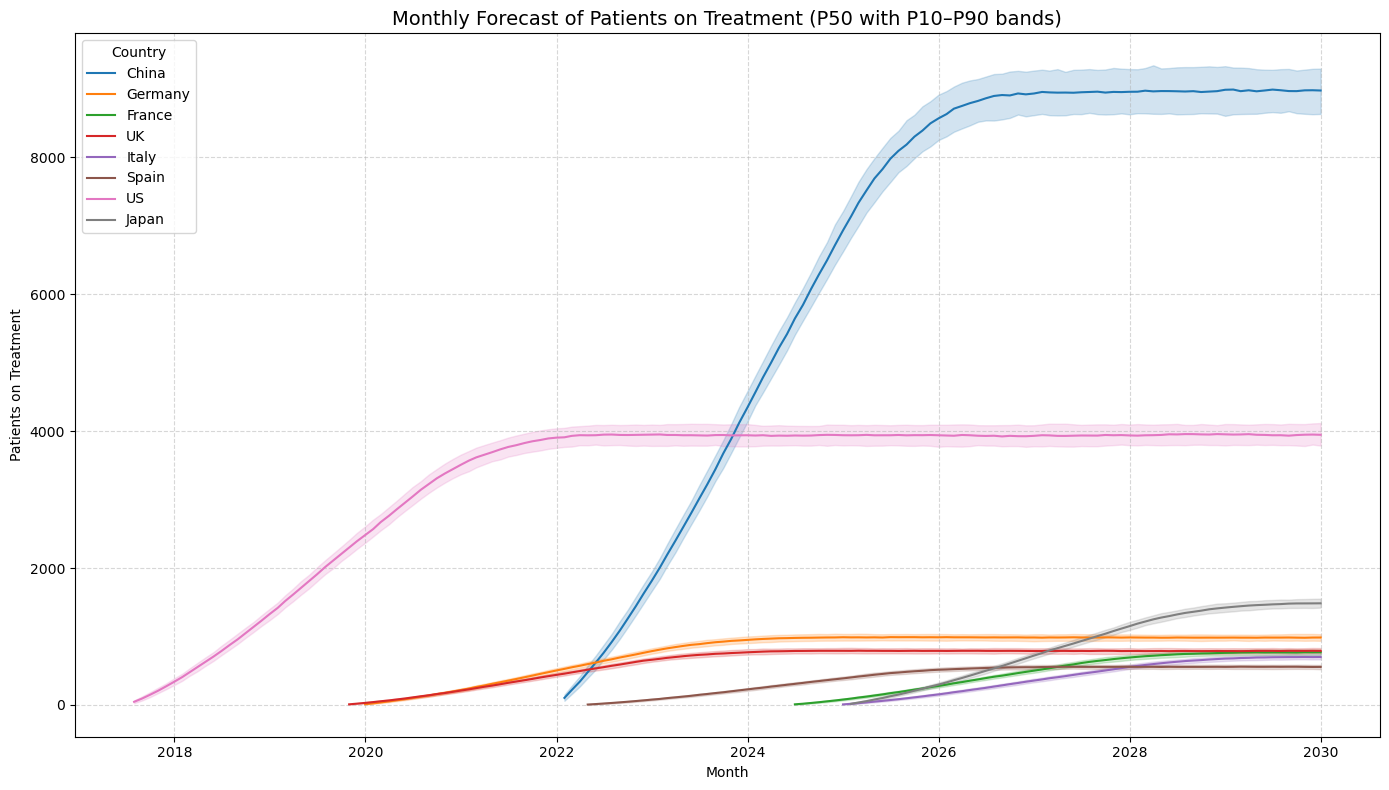

In [6]:
# 📌 Choose desired quantiles
q_low, q_med, q_high = 0.1, 0.5, 0.9

# 🎨 Set up the figure
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10.colors  # distinct colors for up to 10 countries

for idx, (country, data) in enumerate(results.items()):
    # Extract forecast duration and launch date
    launch_date = pd.to_datetime(country_params.loc['launch_date', country])
    n_months = country_params.loc['months_to_forecast', country]
    time_index = pd.date_range(start=launch_date, periods=n_months, freq='M')

    # Extract P10, P50, P90 across simulations (axis=1)
    p10 = np.quantile(data['on_treatment'], q_low, axis=1)
    p50 = np.quantile(data['on_treatment'], q_med, axis=1)
    p90 = np.quantile(data['on_treatment'], q_high, axis=1)

    # Plot median
    plt.plot(time_index, p50, label=country, color=colors[idx % len(colors)])
    # Fill between P10 and P90
    plt.fill_between(time_index, p10, p90, color=colors[idx % len(colors)], alpha=0.2)

# 📑 Chart formatting
plt.title("Monthly Forecast of Patients on Treatment (P50 with P10–P90 bands)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Patients on Treatment")
plt.legend(title="Country")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("../images/multimarket_forecast.png", dpi=300, bbox_inches='tight')
plt.show()


## ✅ Summary: Vectorized Multi-Market Forecasting

In this notebook, I implemented a fully vectorized simulation framework to project patient uptake and treatment persistence for Drug X across multiple international markets. This approach enables efficient execution of hundreds of simulations per country, making it scalable for scenario analysis, sensitivity testing, and strategic planning.

Key takeaways:

- **Vectorization** significantly accelerates simulation runtime, even when modeling many countries over long forecast horizons.
- We produced **probabilistic uptake forecasts** that incorporate uncertainty in incidence, physician behavior, and patient persistence.
- A cross-country visualization using **median and percentile bands** highlighted market-level differences in patient uptake patterns and dynamics.

This framework now serves as a good foundation for deeper comparative analyses, market prioritization, and planning under uncertainty in future work.  
Moreover, establishing a reliable patient forecast baseline enables downstream applications such as **monthly pricing strategy optimization**, **per-patient revenue modeling**, and **SKU-level production planning** based on forecasted patients on treatment.